# bunching estimation using the real data

take concept from simulation

In [7]:
# load packages

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from scipy.optimize import fsolve
from scipy import integrate
from sympy import symbols, solve, Eq
import re
import random
from heapq import nlargest
import tools # this imports the file tools.py // must be in the same folder as the current file

np.random.seed(111)


In [8]:
# load data
wd = Path.cwd()
folder = 'stata'
file = 'Outages_{period}.dta'
zip = 'Outages_{period}.zip'
zip = zipfile.ZipFile(wd.parent/folder/zip)
data = pd.read_stata(zip.open(file)) # convert_categoricals = True
#print(data.columns)

# keep relevant columns
#data = data[['date', 'duration_minutes', 'discom', 'planned', 'noofcustomersaffected', 'unservedmuduetooutage', 'q']]
data['year'] = data.apply(lambda row: row.date.year, axis=1)

# keep year 2019
#data = data[data.apply(lambda row: row.date.year == 2019, axis=1)]

# keep only unplanned
data = data.loc[data.planned != 'planned',]

# at least 100 custumers affected
data = data.loc[data.noofcustomersaffected >= 100]

data.reset_index(drop = True)


# keep one firm
#data = data.loc[data.discom == 'tata',]
data.describe()

,id,noofcustomersaffected,unservedmuduetooutage,hour_of_day,duration_seconds,duration_minutes,duration_hours,industrial,school,hospital,dairy,residential,minute_of_day,q,quarter,hourly,year
count,90073.000000,91230.000000,87085.000000,91230.000000,91230.000000,91230.000000,91230.000000,91230.000000,91230.000000,91230.000000,91230.000000,91230.000000,91230.000000,91230.000000,91230.000000,91230.000000,91230.000000
mean,468.618521,1473.176324,0.000669,12.517867,3769.354072,62.822568,1.047043,0.048690,0.057459,0.016464,0.021638,0.032489,28.942377,2.478779,24711.152344,8401.883789,2018.356725
std,522.128451,1717.586345,0.001240,5.606701,3977.549315,66.292489,1.104875,0.215303,0.232840,0.127211,0.145528,0.177272,17.357660,1.119374,14567.838867,4894.696289,0.604226
min,1.000000,100.000000,-0.013772,0.000000,60.000000,1.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2017.000000
25%,96.000000,305.000000,0.000117,9.000000,1897.000000,31.616667,0.526944,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,1.000000,12115.250000,4262.000000,2018.000000
50%,275.000000,845.000000,0.000305,13.000000,2940.000000,49.000000,0.816667,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,2.000000,23535.000000,7819.000000,2018.000000
75%,639.000000,2019.000000,0.000792,17.000000,4380.000000,73.000000,1.216667,0.000000,0.000000,0.000000,0.000000,0.000000,44.000000,3.000000,37715.000000,12836.000000,2019.000000
max,2986.000000,15574.000000,0.070739,23.000000,245340.000000,4089.000000,68.150000,1.000000,1.000000,1.000000,1.000000,1.000000,59.000000,4.000000,51343.000000,17572.000000,2019.000000


Reason of outages: list of most occuring words

In [6]:
# tidy up 
data['remark_short'] = data.apply(lambda row: row.remarks.replace('\n', ' '), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: row.remark_short.replace('faults', 'fault'), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: row.remark_short.replace('trafic', 'traffic'), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: row.remark_short.replace('tripping', 'trip'), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: row.remark_short.replace('tripped', 'trip'), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: row.remark_short.replace('/', ' '), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: row.remark_short.replace(',', ' '), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: row.remark_short.replace('(', ''), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: row.remark_short.replace(')', ''), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: row.remark_short.strip(), axis = 1)
data.loc[:, 'remark_short'] = data.apply(lambda row: re.sub(' +', ' ',row.remark_short), axis = 1)

# make all remarks in list
remark_list = data.remark_short.tolist()
for i in range(len(remark_list)):
    remark_list[i] = remark_list[i].split()

# list of all words
remark_list_new=[]
for x in remark_list: 
    for i in x:
        i = i.lower() # all lower case
        remark_list_new.append(i)

remark_list = remark_list_new


words_to_remove = ['outage', 'due', 'to', 'and', 'or', 'with', 'for', '.', 'at', 'interruption','schedule', 'on', 'of','system']
# list of words that should not be considered
remark_list = [ w for w in remark_list if w not in words_to_remove]

# list of unique words
remark_unique = list(set(remark_list)) 

# now could the occurences of unique words and save in dictionary
remark_dict = {}
for i in remark_unique:
    remark_dict[i] = remark_list.count(i)

# get most
remark_most = sorted(remark_dict, key = remark_dict.get, reverse=True)[0:20]

# here you can simply add words you want in the table
words_to_count = ['trip', 'storm', 'birdage', 'tree', 'water','load', 'monkey'] 
for w in words_to_count:
    remark_most.append(w)

# extract number of occurences from dict and save in list
remark_most_values = []
for i in remark_most:
    remark_most_values.append(remark_dict[i])

# new dictionary with only the most words
remark_dict = {}
for i in range(len(remark_most)):
    remark_dict[remark_most[i]] = remark_most_values[i]

# put dictionary in df
df = pd.DataFrame.from_dict(remark_dict,orient='index', columns = ['occurences']).reset_index()
df = df.rename(columns={'index':'remark'})
total_remarks = data.remarks.count()

#df['share'] = df.occurences / total_remarks
#df.sort_values(by = ['occurences'])
print(df)
# export df to latex
#df.to_latex('remarks.tex', index=False)

         remark  occurences
0         fault       51543
1         force        5951
2       majeure        5935
3      sabotage        4700
4         cable        1919
5   unschdueled        1383
6            lt        1211
7   maintenance        1151
8          pole        1027
9          rain         991
10         hvds         832
11         fuse         676
12         work         658
13        blown         623
14       faulty         593
15         fire         588
16        vihar         552
17         gali         531
18        burnt         477
19  transformer         477
20         trip         219
21        storm         385
22      birdage         330
23         tree         240
24        water         150
25         load         119
26       monkey           5


$\pi$: revenue loss from outage

Calculation: \
$r =$ unserved kWh / duration of outage \
$\pi = r * tariff$

unserved kWh is a function of the number of customers affected and the duration of the outage

!!! unservedmuduetooutage has missings: pi will also have missings

In [7]:
## calculate pi 

#the tariff is a price per kwh
tariff = 8

data['r_permin'] = data.apply(lambda row: row.unservedmuduetooutage * 1e6 / row.duration_minutes, axis = 1)

data['pi'] = data.r_permin * tariff

pi = data.pi.median()

print('median pi:', pi)


# define parameters 
# let's have the total fine as a separate function that includes phi =50/60 and N
phi = 50/60*data.noofcustomersaffected.median() # should we do that here?
phi120 = 100/60*data.noofcustomersaffected.median()
print(phi, phi120)

median pi: 47.98090185676392
704.1666666666667 1408.3333333333335


density of duration 

(0.0, 420.0)

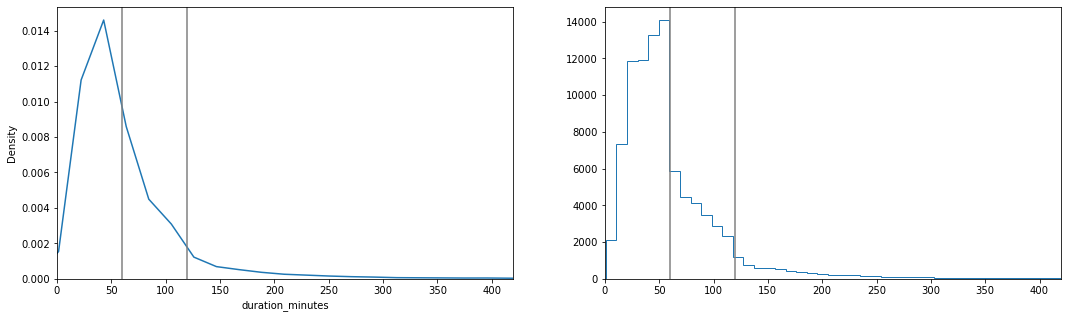

In [8]:
xmax  = 420

fig, axs = plt.subplots(1,2,figsize=(18,5))
sns.kdeplot(data.duration_minutes, ax = axs[0])
axs[0].axvline(60, color  = 'grey')
axs[0].axvline(120, color  = 'grey')
axs[0].set_xlim(0,xmax)

axs[1].hist(data.duration_minutes, histtype = 'step', bins = xmax)
axs[1].axvline(60, color  = 'grey')
axs[1].axvline(120, color  = 'grey')
axs[1].set_xlim(0,xmax)

# Bunching Estimation

In [9]:
# bunching at x = 60
bsize = 1
ex_reg = 10
ex_reg_miss = 20
z = 59
z_lower60 = z - bsize*ex_reg

missing60 = z + ex_reg_miss*bsize

bunch60 = tools.bunching(data.duration_minutes, bsize = bsize, xmax= 115, xmin= 0, z_upper= z, z_lower= z_lower60, missing = missing60, ex_reg= ex_reg, ex_reg_miss=ex_reg_miss, poly_dgr=6)
#print(bunch60.df_count())

display(bunch60.estimation_res())

print('EX:', bunch60.get_deltaX(), 'mX:', bunch60.get_mX(), 'B:', bunch60.get_B())

pred60 = bunch60.prediction()

print('total bunching',bunch60.total_bunch())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nobs   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     452.3
Date:                Fri, 24 Sep 2021   Prob (F-statistic):           3.04e-78
Time:                        15:25:31   Log-Likelihood:                -663.63
No. Observations:                 115   AIC:                             1345.
Df Residuals:                     106   BIC:                             1370.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.5412     49.055      0.561      0.576     -69.715     124.797
duration      10.8439     13.052      0.831      0.408     -15.033      36.721
duration2      4.5289      1.071      4.229      0.000       2.406       6.652
duration3     -0.1817      0.037     -4.956      0.000      -0.254      -0.109
duration4      0.0027      0.001      4.591      0.000       0.002       0.004
duration5    -1.8e-05   4.44e-06     -4.052      0.000   -2.68e-05   -9.19e-06
duration6   4.517e-08   1.27e-08      3.549      0.001    1.99e-08    7.04e-08
b            341.7721     42.059      8.126      0.000     258.385     425.159
m           -139.8720     39.564     -3.535      0.001    -218.311     -61.433
==============================================================================
Omnibus:                        8.850   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.012   Jarque-Bera (JB):               12.160
Skew:                           0.384   Prob(JB):                      0.00229
Kurtosis:                       4.395   Cond. No.                     4.74e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.74e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

EX: 3.4518663643897822 mX: -4.158703352542784 B: 3604.582851710693
total bunching 4.303755439887405


In [10]:
# bunching at x = 120
bsize = 1
ex_reg = 2
z = 119
z_lower120 = z - ex_reg * bsize
missing120 = z + ex_reg * bsize

# define bins

bunch120 = tools.bunching(data.duration_minutes, bsize = bsize, xmax= 160, xmin= 90, z_upper= z, z_lower= z_lower120, missing = missing120, ex_reg= ex_reg, ex_reg_miss = ex_reg_miss, poly_dgr=9, include_missing=False)
#print(bunch120.df_count())

display(bunch120.estimation_res())

print('deltaX:', bunch120.get_deltaX())

pred120 = bunch120.prediction()

print('total bunching',bunch120.total_bunch())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   nobs   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                     265.6
Date:                Fri, 24 Sep 2021   Prob (F-statistic):           2.14e-41
Time:                        15:25:32   Log-Likelihood:                -322.63
No. Observations:                  70   AIC:                             657.3
Df Residuals:                      64   BIC:                             670.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.615e-11   1.07e-11      1.511      0.136    -5.2e-12    3.75e-11
duration   -2.181e-08   1.44e-08     -1.511      0.136   -5.06e-08    7.02e-09
duration2   5.101e-08   3.37e-08      1.512      0.136   -1.64e-08    1.18e-07
duration3   2.073e-06   1.37e-06      1.512      0.136   -6.67e-07    4.81e-06
duration4   5.118e-05   3.38e-05      1.512      0.135   -1.64e-05       0.000
duration5  -5.851e-07   1.07e-06     -0.545      0.587   -2.73e-06    1.56e-06
duration6  -2.306e-09   1.26e-08     -0.183      0.856   -2.75e-08    2.29e-08
duration7   4.831e-11   6.54e-11      0.739      0.463   -8.23e-11    1.79e-10
duration8  -1.471e-13   1.26e-13     -1.168      0.247   -3.99e-13    1.04e-13
duration9  -5.858e-19    7.1e-19     -0.825      0.412      -2e-18    8.32e-19
b          -1.157e-11   7.65e-12     -1.511      0.136   -2.69e-11    3.72e-12
==============================================================================
Omnibus:                        2.605   Durbin-Watson:                   0.923
Prob(Omnibus):                  0.272   Jarque-Bera (JB):                2.195
Skew:                           0.023   Prob(JB):                        0.334
Kurtosis:                       3.866   Cond. No.                     1.10e+25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.26e-11. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

deltaX: 0.45871093334120666
total bunching 0.3648538647129137


plot of counterfactual and actual data

Text(0.5, 0, 'Duration (Minutes)')

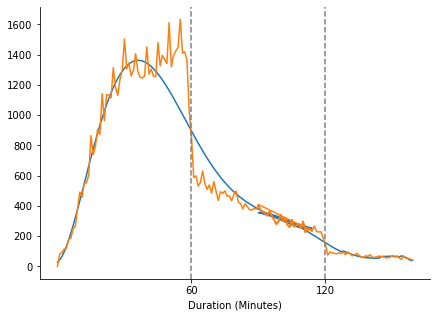

In [11]:
# concat the two predictions
pred = pd.concat([pred60,pred120], ignore_index=True)
#xs = tools.bunching(data.duration_minutes, bsize = bsize, xmax= xmax, xmin= 0, z_upper= z, z_lower= z_lower120, missing = missing120, ex_reg= ex_reg, ex_reg_miss = ex_reg_miss, poly_dgr=6, include_missing=False).df_count()


fig, ax = plt.subplots(figsize=(7,5))
plt.plot(pred.duration, pred.y_pred)
plt.plot(pred.duration, pred.nobs)
plt.axvline(60, color= 'grey', linestyle = 'dashed')
plt.axvline(120, color= 'grey', linestyle = 'dashed')
plt.xticks(ticks = [60, 120])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xlabel('Duration (Minutes)')

Visualize $\Delta x$

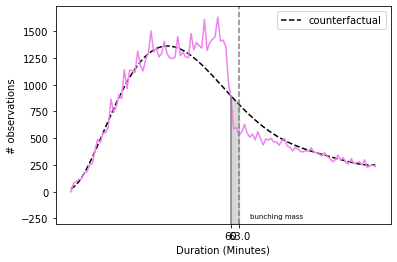

In [12]:
fig, ax = plt.subplots()
b = np.round(60 + bunch60.get_deltaX())
min = -300
plt.plot(pred60.duration[pred60.duration >= 0], pred60.y_pred[pred60.duration >= 0], color = 'black', linestyle='dashed', label = 'counterfactual')
plt.plot(pred60.duration, pred60.nobs, color = 'violet')
plt.plot([60,60], [min,pred60.loc[pred60.duration == 60, 'y_pred'].reset_index(drop=True)[0]], color = 'grey')
plt.axvline(b,color='grey', linestyle = 'dashed')
plt.xlabel('Duration (Minutes)')
plt.ylabel('# observations')
plt.xticks([60 , b], labels = [60,b])
plt.ylim(min,pred60.nobs.max()+ 100)
plt.fill_between(np.linspace(60,b,np.sum((pred60.duration > 60) & (pred60.duration < b))),pred60.y_pred[(pred60.duration > 60) & (pred60.duration < b)], np.repeat(min,np.sum((pred60.duration > 60) & (pred60.duration < b))), alpha = .3, color = 'grey')
plt.annotate('bunching mass', xy = (67,min + 50), size = 7)
plt.legend()

#fig.savefig('xdensity.png',dpi=120, format='png')

solve for $\alpha$ and compare: $K(x^I) = K(x^*)$

$K(x^I) = (\pi + \phi)^{\alpha /1+\alpha} (x^* + \Delta x^*) \pi^{1/1+\alpha}  (1 + 1/\alpha)$


at $x$ around $60$: $\phi = 50$

If $x>120$: $\phi = 100$


I am now doing it for N=1, not sure if that's right. Also, we should double check the functions. What values of $\pi$ and $\phi$ should we use? For $\pi$ we could maybe do a weighted average

alpha: 8.562221098456607 deltax 3.4518663643897822
alpha: 12.142031138233135 deltax 0.45871093334120666


c:\Users\paula\OneDrive\Documents\400_VWL\420 Work\Dana\Dehli_outages\src\tools.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  first = sigma / alpha
<ipython-input-13-7d7de198c625>:25: RuntimeWarning: invalid value encountered in double_scalars
  return L(a) - R(a)


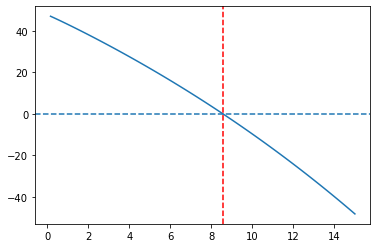

In [13]:
alpha60 = tools.solve_alpha(60, bunch60.get_deltaX(), pi, phi=50/60, phi120 = 100/60, startingvalue = 10)
alpha120 = tools.solve_alpha(120, bunch120.get_deltaX(), pi, phi=50/60, phi120 = 100/60, startingvalue=10)

print('alpha:',alpha60, 'deltax', bunch60.get_deltaX())
print('alpha:',alpha120, 'deltax', bunch120.get_deltaX())

alpha = alpha60
#alpha = 0.8

# plot indifference as a function of alpha
delta_x = bunch60.get_deltaX()
def sigmaI(a):
    return (60 + delta_x)*(pi)**(1/(1+a))

def  xI(a):
    return  sigmaI(a) * (pi+50/60)**(-1/(1+a))

def L(a):
    return tools.K(xI(a), sigmaI(a), pi=pi, phi=50/60, phi120 = 100/60,alpha=a, N=1)
    
def R(a):
    return pi*60 + tools.C(60, sigmaI(a), a) 

def solution(a):
    return L(a) - R(a)

alphas = np.linspace(0,15, 100)
sol =  [solution(a) for a in alphas]
plt.plot(alphas,sol)
plt.axhline(0, linestyle = 'dashed')
plt.axvline(alpha60, linestyle='dashed', color = 'red')

## get counterfactual duration at outage level

!! this is maybe not optimal. Right now, I am assuming a poisson distribution in the bins of the missing mass. \
When you look at the table with the bins, we can see that the excess mass and missing mass do not sum up to zero. Can we solve this issue by improving the bunching estimation?

In [14]:
# first need to get the counterfactuals on the outage-level
cf = pd.concat([pred60,pred120], ignore_index=True)
cf = cf.loc[:,['bin', 'nobs', 'duration', 'b', 'm','y_pred']]

cf['difference'] = cf.nobs - cf.y_pred
# make sure that at least one bin is in missing
upper60 = 60 + bunch60.get_deltaX() + bsize if bunch60.get_deltaX() < bsize else 60 + bunch60.get_deltaX()
upper120 = 120 + bunch120.get_deltaX() + bsize if bunch120.get_deltaX() < bsize else 120 + bunch120.get_deltaX()
# create dummies
cf['b60'] = cf.apply(lambda row: 1 if (row.b ==1) & (row.duration <= missing60) else 0, axis = 1)
cf['missing60'] = cf.apply(lambda row: 1 if (row.duration > 60) & (row.duration <= upper60) else 0, axis = 1)
cf['b120'] = cf.apply(lambda row: 1 if (row.b ==1) & (row.duration >= z_lower120) else 0, axis = 1)
cf['missing120'] = cf.apply(lambda row: 1 if (row.duration > 120) & (row.duration <= upper120) else 0, axis = 1)

# calculate missing
sum60 = cf.loc[(cf.duration > 60) & (cf.duration <= upper60),'y_pred'].sum()
sum120 = cf.loc[(cf.duration > 120) & (cf.duration <= upper120),'y_pred'].sum()

# calculate probability of being in bin
cf['prob'] = 0
cf.loc[(cf.duration > 60) & (cf.duration <= upper60), 'prob'] = cf.y_pred / sum60
cf.loc[(cf.duration > 120) & (cf.duration <= upper120), 'prob'] = cf.y_pred / sum120

print(cf.prob.sum() == 2)
cf[(cf.b60 == 1) | (cf.b120 == 1) | (cf.missing120 == 1) | (cf.missing60 == 1)]

True


,bin,nobs,duration,b,m,y_pred,difference,b60,missing60,b120,missing120,prob
49,"(49, 50)",1342,49,1,0,1187.089789,154.910211,1,0,0,0,0.000000
50,"(50, 51)",1611,50,1,0,1162.914732,448.085268,1,0,0,0,0.000000
51,"(51, 52)",1320,51,1,0,1137.887752,182.112248,1,0,0,0,0.000000
52,"(52, 53)",1395,52,1,0,1112.140042,282.859958,1,0,0,0,0.000000
53,"(53, 54)",1425,53,1,0,1085.799842,339.200158,1,0,0,0,0.000000
54,"(54, 55)",1448,54,1,0,1058.991946,389.008054,1,0,0,0,0.000000
55,"(55, 56)",1633,55,1,0,1031.837257,601.162743,1,0,0,0,0.000000
56,"(56, 57)",1410,56,1,0,1004.452360,405.547640,1,0,0,0,0.000000
57,"(57, 58)",1418,57,1,0,976.949140,441.050860,1,0,0,0,0.000000
58,"(58, 59)",1361,58,1,0,949.434423,411.565577,1,0,0,0,0.000000


In [15]:

## difference in b60 need to be distributed to missing mass
## can we improve this? It is okay but not optimal

data['duration_cf'] = data.duration_minutes

dict = {'60': cf.loc[(cf.b60 ==1) & (cf.difference >0),].index, '120': cf.loc[(cf.b120 ==1) & (cf.difference >0),].index}
dict_m = {'60': cf.missing60, '120':cf.missing120}

for d in ['60','120']:
    ind = dict[d]
    m = dict_m[d]
    for b in ind:
        # select bin
        bin = cf.bin[b]   
        # get 'extra' observations
        diff = np.round(cf.difference[b]).astype(int)
        #print(bin, diff)
        # extract the data in bin and select n = diff random values
        new_data = data.loc[(data.duration_cf >= bin[0]) & (data.duration_cf <= bin[1])].sample(n = diff, axis = 0)
        # now randomly choose a bin in the missing mass, weighted by prob of observations being in that bin bin
        mis = cf.loc[m == 1,].sample(n=1, axis =0, weights = cf.prob).bin.reset_index(drop=True)[0]
        # create n=diff random values in bin
        new = np.random.poisson((mis[1] +  mis[0])/2, size = diff) # here I am assuming a poisson distribution in the bins
        # replace values in new_data
        data.loc[new_data.index.tolist(),'duration_cf'] = new

#data.describe()

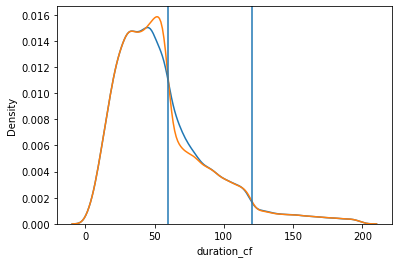

In [16]:
# should look similar to counterfactual density from bunching estimation
sns.kdeplot(data.duration_cf[data.duration_cf < 200])
sns.kdeplot(data.duration_minutes[data.duration_minutes < 200])

plt.axvline(60)
plt.axvline(120)

## calculate the $\sigma$'s based on the counterfactual x's

In [17]:
# this takes some computation time

data['sigma'] = 0

for i in data.index:
    s = symbols('s')
    x = data.loc[i, 'duration_cf']
    N = data.loc[i, 'noofcustomersaffected']
    # should we take pi here at the outage level?
    pi = data.loc[i, 'pi']
    if pi == 0: pi = data.pi.median() # take median for missing values
    if x < 60:
        exp = Eq(tools.xopt(s, pi = pi, phi=0, alpha = alpha), x)
    elif x < 120:
        exp = Eq(tools.xopt(s, pi = pi, phi=50/60, alpha = alpha), x)
    else:   
        exp = Eq(tools.xopt(s, pi = pi, phi=100/60, alpha = alpha), x)
    res = solve(exp,s)
    if len(res) < 1: data.loc[i,'sigma'] = np.nan
    else: data.loc[i,'sigma'] = res[0]

#data

c:\Users\paula\OneDrive\Documents\400_VWL\420 Work\Dana\Dehli_outages\src\tools.py:46: RuntimeWarning: invalid value encountered in double_scalars
  return sigma * ((pi + phi))**(-1/(1+alpha))


In [18]:
#data.head()


count    87082.000000
mean        95.490505
std         98.271573
min          1.242921
25%         47.180608
50%         73.940500
75%        112.817919
max       6151.359261
Name: sigma, dtype: float64

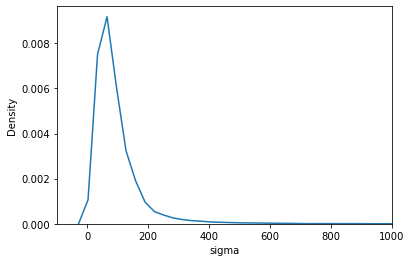

In [19]:
sns.kdeplot(x =data.sigma.astype(float))
plt.xlim(-100,1000)
data.sigma.astype(float).describe()

$K(\sigma,\pi, \phi) = (\pi + \phi)^{\alpha / (1+\alpha)} \sigma (1 + 1/\alpha)$

In [21]:
# calculate K 

# method 1: use function tools.K
#counterfactual cost without a fine (phi=0)
data['cost_cf'] = data.apply(lambda row: tools.K(row.duration_cf, sigma = row.sigma, pi = pi, phi=0, phi120=0, alpha = alpha, N = row.noofcustomersaffected), axis = 1)
# what are the right values for phi?
data['cost_real'] = data.apply(lambda row: tools.K(row.duration_minutes,sigma = row.sigma, pi = pi, phi=phi, phi120=phi120, alpha = alpha, N = row.noofcustomersaffected), axis = 1)

#this is wrong
#data['cost_cf_2pi'] = data.apply(lambda row: tools.K(row.duration_cf, sigma = row.sigma, pi = 2*pi, phi=0, phi120=0, alpha = alpha), axis = 1)

# get difference
# why do we multiply ba 0.014?
print((data.cost_real.sum() - data.cost_cf.sum())*0.014)
#print('doubling pi delta PS:',(data.cost_real.sum() -data.cost_cf_2pi.sum())*0.014)

55468255300.2417 should be negative to be welfare increasing


In [ ]:
#print('doubling pi delta PS:',(data.cost_cf_2pi.sum() -data.cost_cf.sum())*0.014)

# Utility of consumer  𝑖  experiencing an outage:

$U_i=\delta T−\pi (T-x)−(p' + \chi)x + FINE $

T is total time (e.g. 24 hours)

Change in consumer surplus:

$ \Delta U_i = (x^{data} - x^{counterfactual})*(\pi-p')$

Since $x^{data} < x^{counterfactual}$ and $𝑝′≥\pi$, and $\chi>0$, $\Delta U_i\geq0 $


Assumptions:

1-  

2- pollution during an outage is only local

Utility of consumer not experiencing an outage:
$U_i = \delta T - p T - \chi \sum_{i} x_{-i} $

In [22]:
# calculate fine for each outage
data['fine_real'] = data.apply(lambda row: tools.V(phi, phi120, row.duration_minutes, N = row.noofcustomersaffected), axis=1)

data['fine_cf'] = data.apply(lambda row: tools.V(0, 0, row.duration_cf, N = row.noofcustomersaffected), axis=1)

In [25]:
# total time
start = data.start_date.min()
end = data.end_date.max()

time_diff = end-start
T = time_diff.total_seconds() / 60
print('total time in minutes:',T)
#T = 12*365

# health cost
#chi = 391000000/data.duration_minutes.sum()
chi = 515
print('chi:', chi)

# at outage level
data['pprime'] = data.apply(lambda row: (row.unservedmuduetooutage * 1000000/ row.duration_minutes ) * 21 , axis=1) # is that right?
print('median pprime:', data.pprime.median())

### change in CS: xbunch and xcounter

data['CS_cf'] = data.apply(lambda row: (- pi * (T-row.duration_cf) - row.pprime*row.duration_cf), axis = 1)
##data['CS_cf_nopol'] = data.apply(lambda row: (- pi * (T-row.duration_cf) - pprime*row.duration_cf ), axis = 1)
#data['CS_cf_2pi'] = data.apply(lambda row: (- 2*pi * (T-row.duration_cf) - pprime*row.duration_cf - chi*row.duration_cf, axis = 1)
#data['CS_cf_nopol_2pi'] = data.apply(lambda row: (- 2*pi * (T-row.duration_cf) - pprime*row.duration_cf ), axis = 1)

data['CS_real'] = data.apply(lambda row: (- pi * (T-row.duration_minutes) - row.pprime*row.duration_minutes + row.fine_real), axis = 1)
#data['CS_real_nopol'] = data.apply(lambda row: (- pi * (T-row.duration_minutes) - pprime*row.duration_minutes + row.fine_real), axis = 1)


# get difference
print('CS with pollution', (data.CS_real.sum() - data.CS_cf.sum())*0.014) #, 'CS No Pollution', (data.CS_real_nopol.sum() - data.CS_cf_nopol.sum())*0.014,)
#print('CS double PI', (data.CS_cf_2pi.sum() - data.CS_cf.sum())*0.014)

1137600.0
chi: 515
median pprime: 125.9498673740053
CS with pollution 55539228809.08982


In [26]:
#back of the envelope calculation (total kwh lost * price difference per kwh)--> corresponds to counterfactual of removing outages completely
print(data.unservedmuduetooutage.sum()*10000000* (7-18))

-6408800569.490002


In [27]:
## Total change in Welfare 35357207.35

print('change in welfare with pollution is: USD', (data.CS_real.sum() - data.CS_cf.sum() - (data.cost_real.sum() - data.cost_cf.sum()))*0.014) #, 'change in welfare without pollution is: USD', (data.CS_real_nopol.sum() - data.CS_cf_nopol.sum() - (data.cost_real.sum() - data.cost_cf.sum()))*0.014)

change in welfare with pollution is: USD 70973508.8481426


In [28]:
print((data.duration_minutes.sum() - data.duration_cf.sum())/91230)

-0.30924604479520557
